In [80]:
from utils import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy import signal
plt.style.use("light")

PATH = "/home/max/Temp/Praktikum/experiments/"

In [132]:
class GuidewireExperiment:
    def __init__(self, positions):
        self.positions = positions
        self.timesteps = len(self.positions)
        self.n_spheres = len(self.positions["0"]["sphere"])
        self.sphere_pos = self.get_all_spheres()
        self.total_time = self.get_total_time()
        self.elapsed_time = self.get_elapsed_time()
        self.delta = self.get_delta()

    def get_all_spheres(self):
        return np.array([self.get_sphere_position(idx) for idx in range(self.n_spheres)])

    def get_sphere_position(self, idx):
        sphere_pos = np.array(
            [
                np.array(
                    [
                        self.positions[str(i)]["sphere"][str(idx)]["x"],
                        self.positions[str(i)]["sphere"][str(idx)]["y"],
                        self.positions[str(i)]["sphere"][str(idx)]["z"],
                    ]
                )
                for i in range(0, self.timesteps)
            ]
        )
        return sphere_pos  # - sphere_pos[0]

    def get_total_time(self):
        total_time = [self.positions[str(i)]["totalTime"] for i in range(0, self.timesteps)]
        return total_time

    def get_elapsed_time(self):
        elapsed_time = [self.positions["0"]["elapsedMilliseconds"]]
        for i in range(1, self.timesteps):
            elapsed_time.append(elapsed_time[-1] + self.positions[str(i)]["elapsedMilliseconds"])
        # elapsed_time = [self.positions[str(i)]["elapsedMilliseconds"] for i in range(0, self.timesteps)]
        return np.array(elapsed_time)

    def get_delta(self):
        delta = np.array([self.positions[str(i)]["delta"] for i in range(0, self.timesteps)])
        return delta

    def plot_sphere(self, idx, axis=0):
        sphere_pos = self.get_sphere_position(idx)

        plt.figure(figsize=(5, 5), dpi=70)
        plt.plot(sphere_pos[:, axis])
        plt.xlabel("Timestep")
        plt.ylabel("Position [m]")
        plt.show()

    def plot_all_spheres(self, axis=0):
        sphere_matrix = self.sphere_pos[:, :, axis] - self.sphere_pos[:, 0, axis, np.newaxis]
        # sphere_matrix -= np.min(sphere_matrix)

        plt.figure(figsize=(6, 5), dpi=70)
        plt.imshow(sphere_matrix, aspect="auto", cmap="turbo")
        plt.xlabel("Timestep")
        plt.ylabel("Sphere Index")
        plt.colorbar(label="Position [m]")
        plt.show()

    def plot_experiment(self):

        time_array = self.get_elapsed_time() / 1000
        sphere_pos = self.get_sphere_position(self.n_spheres - 1)

        fig, ax = plt.subplots(3, 1, figsize=(7, 7), dpi=70)

        ax[0].plot(time_array, self.get_total_time())
        ax[0].set_title("Total Time")
        ax[0].set_ylabel("In-Game Time [s]")
        ax[0].set_xlabel("Real time [s]")

        ax[1].plot(time_array, sphere_pos[:, 2])
        ax[1].set_title("Last Sphere Displacement")
        ax[1].set_ylabel("Displacement [m]")
        ax[1].set_xlabel("Real time [s]")

        ax[2].plot(time_array, self.get_delta())
        ax[2].set_title("Simulation Error")
        ax[2].set_ylabel("Delta [a.u.]")
        ax[2].set_xlabel("Real time [s]")

        plt.tight_layout()
        plt.show()


def plot_confidence_interval(x, y, xlabel, ylabel):
    #fig = plt.figure(figsize=(12, 5), dpi=300)
    
    # Get percentiles for the confidence interval
    p10 = np.percentile(y, axis=0, q=[10]).ravel()[:]
    p90 = np.percentile(y, axis=0, q=[90]).ravel()[:]
    p25 = np.percentile(y, axis=0, q=[25]).ravel()[:]
    p75 = np.percentile(y, axis=0, q=[75]).ravel()[:]
    
    # Plot mean and confidence
    plt.fill_between(x, p10, p90, alpha=0.1, color="b", label="$90\%$ CI")
    plt.fill_between(x, p25, p75, alpha=0.25, color="b", label="$75\%$ CI")
    plt.plot(x, np.mean(y, axis=0)[:], "o-", color="black", label="Mean")
    
    # Labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    #return fig

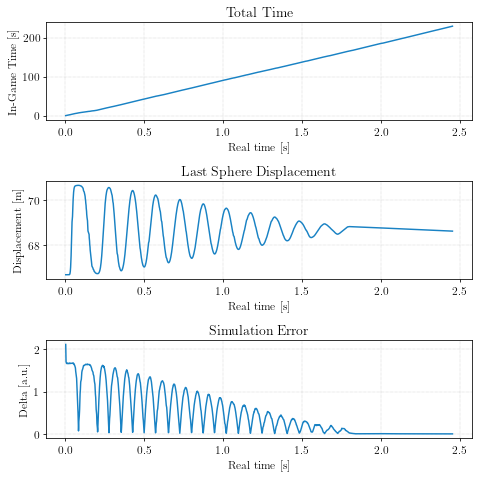

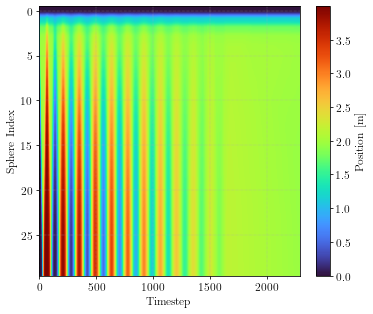

In [133]:
positions = read_json_file("/home/max/Temp/Praktikum/experiments/constraint_solver_steps_1/constraint_solver_steps_1_100/positions.json")

experiment1 = GuidewireExperiment(positions)

experiment1.plot_experiment()
experiment1.plot_all_spheres(axis=2)

In [134]:
def func(x, a, b,c):
    return a*np.exp(-x/b)+c

def get_decay_rate(experiment, debug=False):
    xs = np.arange(0, experiment.timesteps)

    data = experiment.get_sphere_position(experiment.n_spheres-1)[:,2]
    data = data - data[0]

    # Find the upper peaks of the damped oscillation
    peak_idxs,_ = signal.find_peaks(data)

    peaks_positions = xs[peak_idxs]
    peaks_values = data[peak_idxs]
    
    # Fit exponential decay to the peaks
    popt, pcov = curve_fit(func, peaks_positions, peaks_values, p0=[1, 100,2])

    if debug:
        plt.title(f"Decay rate: {popt[1]:.5f}")
        plt.plot(xs, data, label="Data")
        plt.scatter(xs[peak_idxs], data[peak_idxs], c="red")
        plt.plot(xs, func(xs, *popt), label="Fitted Curve")
        plt.xlabel("Time steps")
        plt.ylabel("Displacement [a.u.]")
        plt.show()
        
    return popt[1],popt[0]

In [135]:
def get_all_data(name, parameters):
    relaxation_times = []
    offsets = []
    loop_times = []
    
    for run in range(3):
        relaxation_time = []
        offset = []
        loop_time = []
        
        for p in parameters:
            positions = read_json_file(PATH + f"{name}_{run}/{name}_{run}_{p}/positions.json")
            experiment = GuidewireExperiment(positions)
            
            decay_rate, omega = get_decay_rate(experiment, debug=False)
            times = np.diff(experiment.get_elapsed_time())
            
            loop_time.append(np.mean(times))
            relaxation_time.append(decay_rate)
            offset.append(omega)
            
        relaxation_times.append(relaxation_time)
        offsets.append(offset)
        loop_times.append(loop_time)
    return np.array(relaxation_times), np.array(offsets), np.array(loop_times)

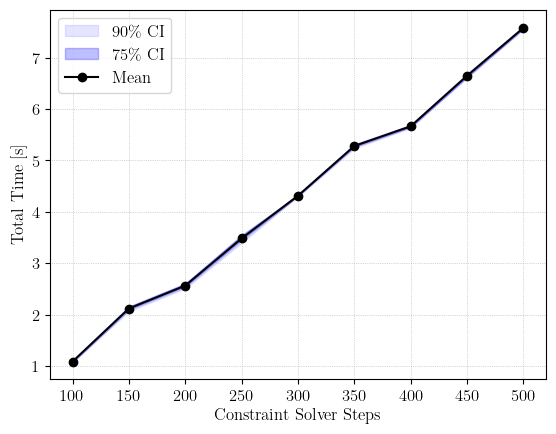

In [136]:
constraint_solver_steps = np.arange(100,550,50)

relaxation_times, offsets, loop_times = get_all_data("constraint_solver_steps", constraint_solver_steps)

plot_confidence_interval(constraint_solver_steps, loop_times, "Constraint Solver Steps", "Total Time [s]")
plt.show()

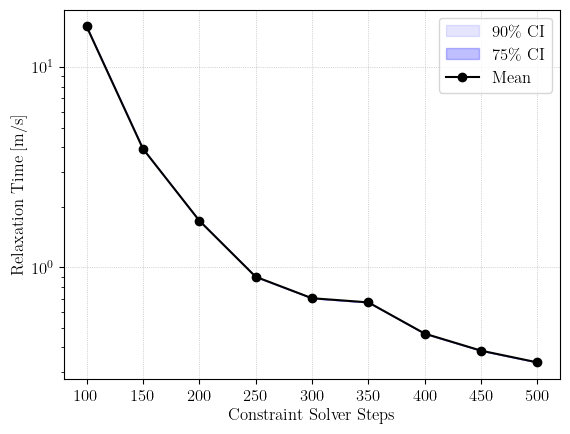

In [137]:
plot_confidence_interval(constraint_solver_steps, relaxation_times/1000, "Constraint Solver Steps", "Relaxation Time [m/s]")
plt.yscale("log")
plt.show()

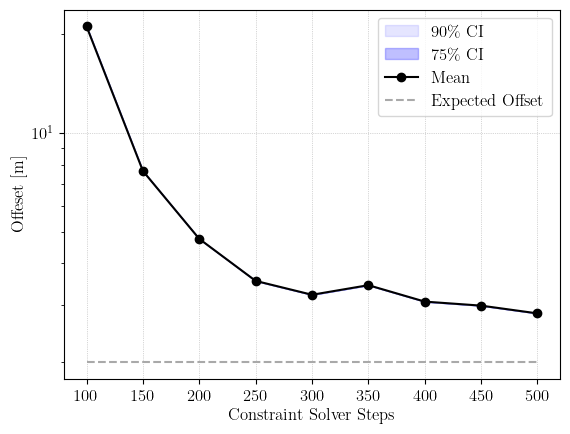

In [138]:
plot_confidence_interval(constraint_solver_steps, offsets, "Constraint Solver Steps", "Offeset [m]")
plt.hlines(2,100,500, color="darkgray", linestyle="--", label="Expected Offset")
plt.yscale("log")
plt.legend()
plt.show()

# Time steps

In [150]:
timesteps = np.logspace(-4, 0, 10)

relaxation_times, offsets, loop_times = get_all_data("time_steps", timesteps)

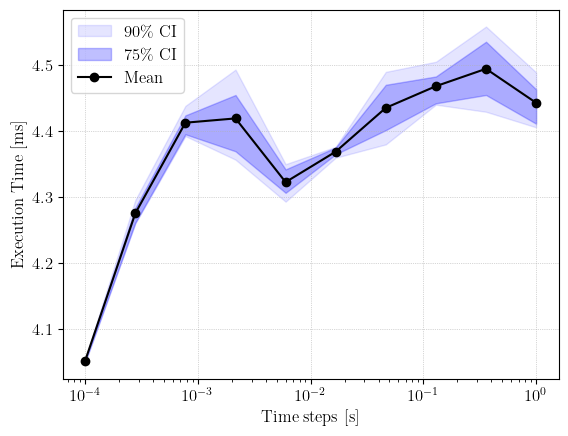

In [151]:
plot_confidence_interval(timesteps, loop_times, "Time steps [s]", "Execution Time [ms]")
plt.xscale("log")
plt.show()

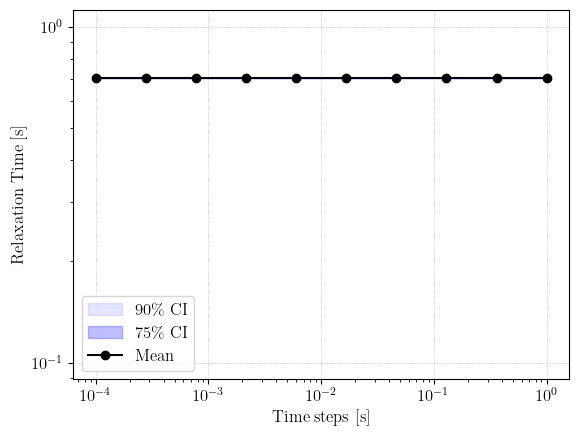

In [152]:
plot_confidence_interval(timesteps, relaxation_times/1000, "Time steps [s]", "Relaxation Time [s]")
plt.xscale("log")
plt.yscale("log")
plt.show()

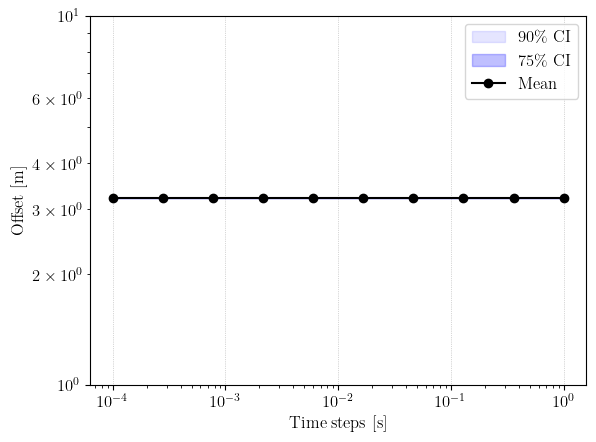

: 

In [153]:
plot_confidence_interval(timesteps, offsets, "Time steps [s]", "Offset [m]")
plt.xscale("log")
plt.yscale("log")  
plt.show()

# Rod Element Length

In [141]:

elements = np.arange(10,110,10).astype("float")

relaxation_times, offsets, loop_times = get_all_data("rod_elements", elements)

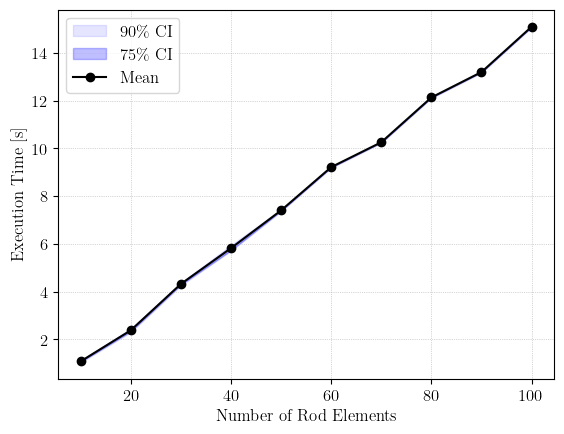

In [142]:
plot_confidence_interval(elements, loop_times, "Number of Rod Elements", "Execution Time [s]")
plt.show()

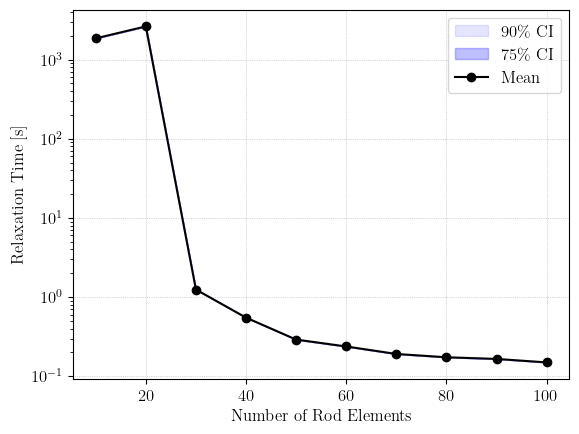

In [143]:
plot_confidence_interval(elements, relaxation_times/1000, "Number of Rod Elements", "Relaxation Time [s]")
plt.yscale("log")
plt.show()

[]

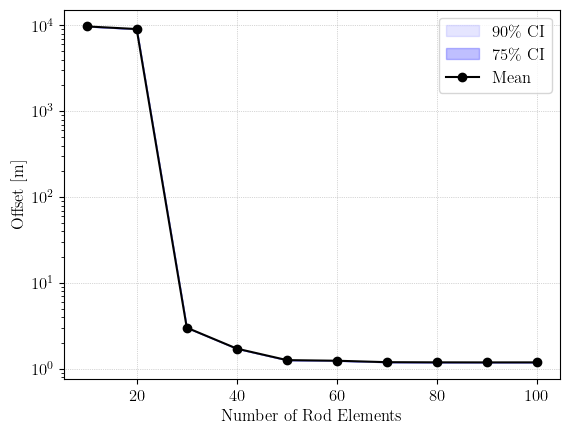

In [144]:
plot_confidence_interval(elements, offsets, "Number of Rod Elements", "Offset [m]")
plt.yscale("log")
plt.plot()


# Displacement

In [145]:

displacements = np.linspace(0.01,5, 30)[8:]

relaxation_times, offsets, loop_times = get_all_data("displacemen", displacements)

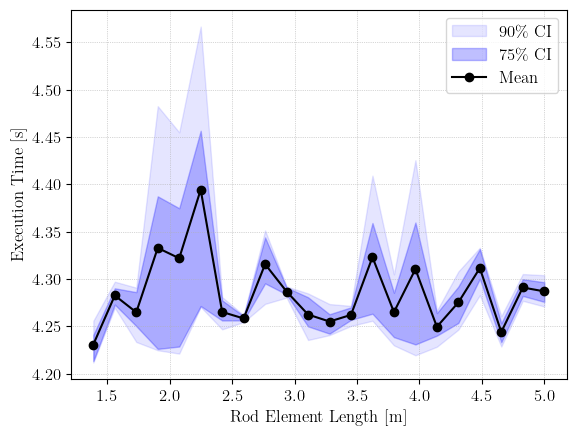

In [146]:
plot_confidence_interval(displacements, loop_times, "Rod Element Length [m]", "Execution Time [s]")
plt.show()

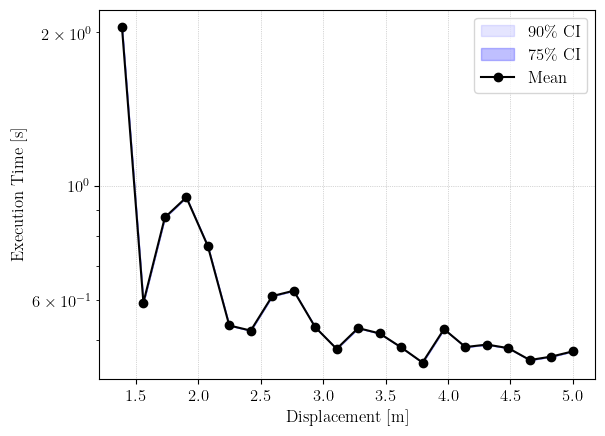

In [147]:
plot_confidence_interval(displacements, relaxation_times/1000, "Displacement [m]", "Execution Time [s]")
plt.yscale("log")
plt.show()

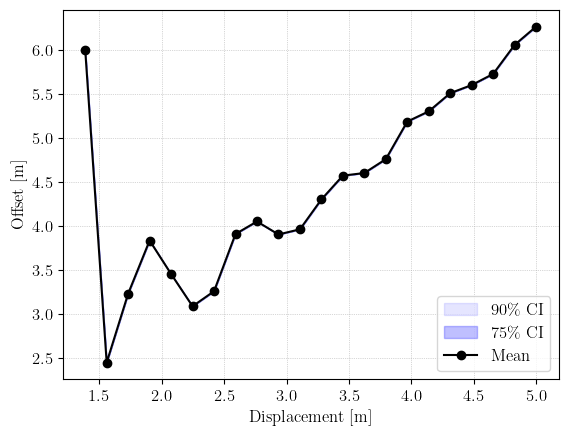

In [148]:
plot_confidence_interval(displacements, offsets, "Displacement [m]", "Offset [m]")
#plt.yscale("log")
plt.show()